In [1]:
import sys
sys.path.append('..')
import os
from argparse import Namespace
import time
import sys
import pprint
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from datasets import augmentations
from utils.common import tensor2im, log_input_image
from models.psp import pSp

## Download Pretrained Models

In [2]:
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory ../pretrained_models. """
    current_directory = os.getcwd()
    save_path = os.path.join("..", "pretrained_models")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url

In [3]:
model_path = {"id": "1bMTNWkh5LArlaWSc_wa8VKyq2V42T2z0", 
              "name": "psp_ffhq_encode.pt"}
download_command = get_download_model_command(file_id=model_path["id"], file_name=model_path["name"])

In [4]:
!{download_command}

--2022-02-22 17:15:55--  https://docs.google.com/uc?export=download&confirm=t&id=1bMTNWkh5LArlaWSc_wa8VKyq2V42T2z0
Resolving docs.google.com (docs.google.com)... 142.250.186.174, 2a00:1450:4001:82b::200e
Connecting to docs.google.com (docs.google.com)|142.250.186.174|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-10-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pen2egg6nqb494r2teri8g1i777lj7cc/1645546500000/17930361707849974000/*/1bMTNWkh5LArlaWSc_wa8VKyq2V42T2z0?e=download [following]
--2022-02-22 17:15:55--  https://doc-10-0o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/pen2egg6nqb494r2teri8g1i777lj7cc/1645546500000/17930361707849974000/*/1bMTNWkh5LArlaWSc_wa8VKyq2V42T2z0?e=download
Resolving doc-10-0o-docs.googleusercontent.com (doc-10-0o-docs.googleusercontent.com)... 142.250.186.129, 2a00:1450:4001:82a::2001
Connecting to doc-10-0o-docs.googleusercontent.com (doc-10-0o-docs.

## Define Parameter

In [5]:
model_path = f"../pretrained_models/{model_path['name']}"
image_path = "./images/input_img.jpg"
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [6]:
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
pprint.pprint(opts)

{'batch_size': 8,
 'board_interval': 50,
 'checkpoint_path': None,
 'dataset_type': 'ffhq_encode',
 'device': 'cuda:0',
 'encoder_type': 'GradualStyleEncoder',
 'exp_dir': '',
 'id_lambda': 0.1,
 'image_interval': 100,
 'input_nc': 3,
 'l2_lambda': 1.0,
 'l2_lambda_crop': 0,
 'label_nc': 0,
 'learn_in_w': False,
 'learning_rate': 0.0001,
 'lpips_lambda': 0.8,
 'lpips_lambda_crop': 0,
 'max_steps': 300000,
 'optim_name': 'ranger',
 'resize_factors': None,
 'save_interval': 1000,
 'start_from_latent_avg': True,
 'stylegan_weights': '',
 'test_batch_size': 8,
 'test_workers': 2,
 'train_decoder': False,
 'val_interval': 2500,
 'w_norm_lambda': 0,
 'workers': 8}


In [7]:
opts['checkpoint_path'] = model_path
if 'learn_in_w' not in opts:
    opts['learn_in_w'] = False
if 'output_size' not in opts:
    opts['output_size'] = 1024

In [8]:
opts = Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading pSp from checkpoint: ../pretrained_models/psp_ffhq_encode.pt
Model successfully loaded!


## Visualize Input

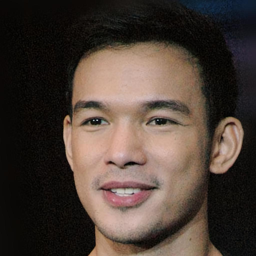

In [9]:
original_image = Image.open(image_path)
if opts.label_nc == 0:
    original_image = original_image.convert("RGB")
else:
    original_image = original_image.convert("L")
original_image.resize((256, 256))

## Align Image

In [10]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

--2022-02-22 17:16:21--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2.2’

shape_predictor_68_ 100%[===================>]  61,07M  18,5MB/s    in 4,1s    

2022-02-22 17:16:25 (14,9 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2.2’ saved [64040097/64040097]

bzip2: Output file shape_predictor_68_face_landmarks.dat already exists.


In [11]:
def run_alignment(image_path):
    import dlib
    from scripts.align_all_parallel import align_face
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
    aligned_image = align_face(filepath=image_path, predictor=predictor)
    print("Aligned image has shape: {}".format(aligned_image.size))
    return aligned_image

Aligned image has shape: (256, 256)


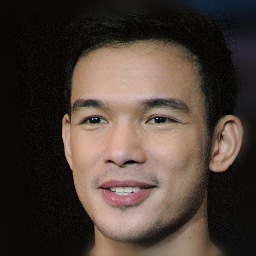

In [12]:
input_image = run_alignment(image_path)
input_image.resize((256, 256))

## Inference

In [13]:
transformed_image = transform(input_image)

In [17]:
NOISE_SCALE = 0.5
latent_mask = None
with torch.no_grad():
    tic = time.time()
    x = transformed_image.unsqueeze(0).cuda().float()
    result_image = net(x, randomize_noise=False, noise_scale=NOISE_SCALE)[0]
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

Inference took 0.0957 seconds.


## Visualize Result

In [18]:
input_vis_image = log_input_image(transformed_image, opts)
output_image = tensor2im(result_image)
res = np.concatenate([np.array(input_vis_image.resize((256, 256))),
                      np.array(output_image.resize((256, 256)))], axis=1)

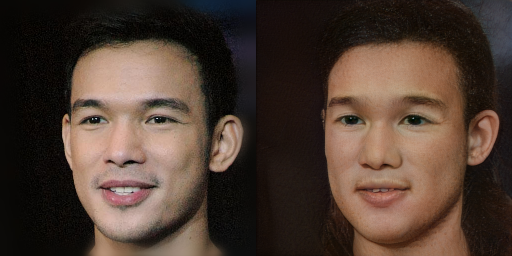

In [19]:
res_image = Image.fromarray(res)
res_image